In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy

import numpy as np

In [2]:
snames = np.asarray(['AMV', 'W_S', 'S_S', 'W_M', 'S_M', 'W_N', 'S_N', 'W_S_w', 'S_S_w', 'W_M_w', 'S_M_w', 'W_N_w', 'S_N_w'])
lnames = ['AMV', 'Winter South', 'Summer South', 'Winter Middle', 'Summer Middle', 'Winter North', 'Summer North', 'Winter South', 'Summer South', 'Winter Middle', 'Summer Middle', 'Winter North', 'Summer North']
imins  = [-75,   -40,   -60,   -80,   -60,   -60,   -60,   -50,     -60,     -80,      -60,    -60,      -45]
imaxs  = [0,     -10,   -10,   -30,   -20,   -20,   -20,   -10,     -20,     -30,      -25,    -20,      0]
jmins  = [0,     10,    20,    25,    35,    45,    50,    10,      15,      25,       30,     40,       45]
jmaxs  = [60,    35,    35,    50,    50,    70,    70,    25,      30,      35,       45,     60,       60]

In [32]:
def plot_globaly(plot_data,title,tcol,figfile,vmin,vmax,season,sss):
    fig   = plt.figure(figsize=(20,20))
    fsize = 16
    ax    = plt.axes([0,0,0.5,1],projection=ccrs.PlateCarree())
    ax.set_extent([-100,20,0,80])
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='0.5'))
    ax.coastlines()
    ax.gridlines()

    plt.pcolormesh(lon,lat,plot_data,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap)
    cb = plt.colorbar(extend='both',orientation='horizontal')
    cb.ax.tick_params(labelsize=fsize)
    cb.set_label('temperature anomaly ($^\circ$C)',size=fsize)
    plt.title(title,fontsize=fsize,color=tcol)
    
    if var_ts == 'max_lats':
        ll = ''
    elif var_ts == 'max_wind':
        ll = '_w'
    
    if season == 'Winter':
        ss = 'W'
    elif season == 'Summer':
        ss = 'S'
    
    col = 'C4'
    ii = np.squeeze(np.where(snames == (ss + '_S' + ll)))
    imin = imins[ii]
    imax = imaxs[ii]
    jmin = jmins[ii]
    jmax = jmaxs[ii]
    plt.text(imin+2.5,jmin+2.5,lnames[ii],fontsize=16,color=col)
    plt.plot([imin,imin,imax,imax,imin],[jmin,jmax,jmax,jmin,jmin],color=col,lw=3)
    print(imin)
    tsfile = ('tos_' + str(imin) + 'to' + str(imax) + 'E_' + str(jmin)  + 'to' + str(jmax) + 'N')
    tsfile = (datadir + EXP + '_' + var_ts + '-' + season_ts[sss] + '_' + tsfile + '_std.nc')
    
    ncid   = Dataset(infile,'r')
    lags   = ncid.variables['lags'][:]
    models2 = ncid.variables['models'][:]
    data_mean = ncid.variables['mean'][:,:]
    data_min0 = ncid.variables['min_std0'][:,:,:]
    data_max0 = ncid.variables['max_std0'][:,:,:]
    data_min1 = ncid.variables['min_std1'][:,:,:]
    data_max1 = ncid.variables['max_std1'][:,:,:]
    ncid.close()

    # Remove problem models:
    for pp in p_models:
        ii = np.where(models2 == pp)
        models2    = np.delete(models2,ii,axis=0)
        data_mean = np.delete(data_mean,ii,axis=0)
        data_min0 = np.delete(data_min0,ii,axis=0)
        data_max0 = np.delete(data_max0,ii,axis=0)
        data_min1 = np.delete(data_min1,ii,axis=0)
        data_max1 = np.delete(data_max1,ii,axis=0)
        
    nm = len(models2)
    nl = np.size(lags)

    # Reshape and redefine lags to be months since middle of season:
    lags = lags*12
    lags = np.tile(lags,(12,1)).T
    for mm in range(0,12):
        lags[:,mm] = lags[:,mm] + mm
    lags = np.ndarray.flatten(lags)
    if season_ts == 'DJF':
        lags = lags - 1

    data_min0 = np.reshape(data_min0,(nm,nl*12))
    data_max0 = np.reshape(data_max0,(nm,nl*12))
    data_min1 = np.reshape(data_min1,(nm,nl*12))
    data_max1 = np.reshape(data_max1,(nm,nl*12))
    
    # Smooth data with running mean:
    rm = 3
    data_min0_f = np.zeros((nm,nl*12-rm+1),'float')
    data_max0_f = np.zeros((nm,nl*12-rm+1),'float')
    data_min1_f = np.zeros((nm,nl*12-rm+1),'float')
    data_max1_f = np.zeros((nm,nl*12-rm+1),'float')

    lags_f      = np.convolve(lags,     1/rm*np.ones(3,'float'),mode='valid')
    for mm in range(0,nm):
        data_min0_f[mm,:] = np.convolve(data_min0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
        data_max0_f[mm,:] = np.convolve(data_max0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
        data_min1_f[mm,:] = np.convolve(data_min1[mm,:],1/rm*np.ones(3,'float'),mode='valid')
        data_max1_f[mm,:] = np.convolve(data_max1[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    
    ax = plt.axes([0.5,2/3,0.5,1/3])
    plt.plot(lags_f,np.mean(data_max1_f-data_min1_f,axis=0),lw=3,color='k',label='MMM')
    plt.fill_between(lags_f,np.min(data_max1_f-data_min1_f,axis=0),np.max(data_max1_f-data_min1_f,axis=0),color='k',alpha=0.1,label='range')
    plt.fill_between(lags_f,np.quantile(data_max1_f-data_min1_f,0.25,axis=0),np.quantile(data_max1_f-data_min1_f,0.75,axis=0),color='k',alpha=0.4,label='mid. 50%')
    plt.axhline(y=0,color='k',lw=1)
    plt.axvline(x=0,color='k',lw=1)
    plt.legend(fontsize=16)

    
    col = 'C2'
    ii = np.squeeze(np.where(snames == (ss + '_M' + ll)))
    imin = imins[ii]
    imax = imaxs[ii]
    jmin = jmins[ii]
    jmax = jmaxs[ii]
    plt.text(imin+2.5,jmin+2.5,lnames[ii],fontsize=16,color=col)
    plt.plot([imin,imin,imax,imax,imin],[jmin,jmax,jmax,jmin,jmin],color=col,lw=3)

    col = 'C1'
    ii = np.squeeze(np.where(snames == (ss + '_N' + ll)))
    imin = imins[ii]
    imax = imaxs[ii]
    jmin = jmins[ii]
    jmax = jmaxs[ii]
    plt.text(imin+2.5,jmin+2.5,lnames[ii],fontsize=16,color=col)
    plt.plot([imin,imin,imax,imax,imin],[jmin,jmax,jmax,jmin,jmin],color=col,lw=3)
        
    plt.show()

    #fig.savefig(figfile,dpi=100,bbox_inches='tight', pad_inches=0.1)

In [33]:
datadir = '/gws/nopw/j04/acsis/jmecking/CMIP6/composites/'
figdir  = 'jet_figures/211005'

EXP          = 'piControl'
var_ts       = 'max_lats'
#var_ts       = 'max_wind'
var_field    = 'tos'
season_ts    = ['DJF','MAM','JJA','SON']
season_field = ['DJF','MAM','JJA','SON']
ns = len(season_ts)

p_models  = ['CESM2-FV2_r1i1p1f1', 'NESM3_r1i1p1f1','EC-Earth3_r1i1p1f1','FGOALS-f3-L_r1i1p1f1', 'FIO-ESM-2-0_r1i1p1f1']
# Problem with these models - need to investigate!
plot_lag = 0

cmap  = plt.get_cmap('seismic',21)
vmin  = -0.5*1.05
vmax  = 0.5*1.05
vmind = -1*1.05
vmaxd = 1*1.05
if var_ts == 'max_lats':
    lmin  = 'southernly jet (< mean - std)'
    lmax  = 'northernly jet (> mean + std)'
elif var_ts == 'max_wind':
    lmin  = 'weak jet (< mean - std)'
    lmax  = 'strong jet (> mean + std)'
    
infile = (datadir + EXP + '_' + var_ts + '-' + season_ts[0] + '_' + var_field + '-' + season_field[0] +'_std.nc' )
    
# Read in information:
ncid   = Dataset(infile,'r')
lon    = ncid.variables['lon'][:]
lat    = ncid.variables['lat'][:]
ncid.close()

In [34]:
# Loop through each season combination and compute data:
mean_MMM = np.zeros((ns,np.size(lat),np.size(lon)),'float')
min0_MMM = np.zeros((ns,np.size(lat),np.size(lon)),'float')
max0_MMM = np.zeros((ns,np.size(lat),np.size(lon)),'float')
min1_MMM = np.zeros((ns,np.size(lat),np.size(lon)),'float')
max1_MMM = np.zeros((ns,np.size(lat),np.size(lon)),'float')

for ss in range(0,1):#ns):
    infile = (datadir + EXP + '_' + var_ts + '-' + season_ts[ss] + '_' + var_field + '-' + season_field[ss] +'_std.nc' )
    
    # Read in information:
    ncid   = Dataset(infile,'r')
    lags   = ncid.variables['lags'][:]
    models = ncid.variables['models'][:]
    ncid.close()

    nm = len(models)
    print(nm)
    nl = np.size(lags)

    ll = np.squeeze(np.where(lags == plot_lag))
    
    cc = 0
    for mm in range(0,nm):
        print(models[mm])
        model = models[mm].split('_')[0]
        ENS   = models[mm].split('_')[1]

        ncid      = Dataset(infile,'r')
        data_mean = ncid.variables['mean'][mm,:,:]
        data_min0 = ncid.variables['min_std0'][mm,ll,:,:]
        data_max0 = ncid.variables['max_std0'][mm,ll,:,:]
        data_min1 = ncid.variables['min_std1'][mm,ll,:,:]
        data_max1 = ncid.variables['max_std1'][mm,ll,:,:]
        ncid.close()

        if models[mm] not in p_models:
            cc = cc + 1
            mean_MMM[ss,:,:] = mean_MMM[ss,:,:] + data_mean
            min0_MMM[ss,:,:] = min0_MMM[ss,:,:] + data_min0
            max0_MMM[ss,:,:] = max0_MMM[ss,:,:] + data_max0
            min1_MMM[ss,:,:] = min1_MMM[ss,:,:] + data_min1
            max1_MMM[ss,:,:] = max1_MMM[ss,:,:] + data_max1

    mean_MMM[ss,:,:] = mean_MMM[ss,:,:]/cc
    min0_MMM[ss,:,:] = min0_MMM[ss,:,:]/cc
    max0_MMM[ss,:,:] = max0_MMM[ss,:,:]/cc 
    min1_MMM[ss,:,:] = min1_MMM[ss,:,:]/cc
    max1_MMM[ss,:,:] = max1_MMM[ss,:,:]/cc 
    
# Remove problem models:
for pp in p_models:
    ii = np.where(models == pp)
    models    = np.delete(models,ii,axis=0)
    data_mean = np.delete(data_mean,ii,axis=0)
    data_min0 = np.delete(data_min0,ii,axis=0)
    data_max0 = np.delete(data_max0,ii,axis=0)
    data_min1 = np.delete(data_min1,ii,axis=0)
    data_max1 = np.delete(data_max1,ii,axis=0)

nm = len(models)
print(nm)

39
ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CAMS-CSM1-0_r1i1p1f1
CAS-ESM2-0_r1i1p1f1
CESM2_r1i1p1f1
CESM2-FV2_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2-WACCM-FV2_r1i1p1f1
CIESM_r1i1p1f1
CMCC-CM2-SR5_r1i1p1f1
CNRM-CM6-1_r1i1p1f2
CNRM-CM6-1-HR_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
EC-Earth3_r1i1p1f1
EC-Earth3-AerChem_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3-Veg-LR_r1i1p1f1
FGOALS-f3-L_r1i1p1f1
FGOALS-g3_r1i1p1f1
FIO-ESM-2-0_r1i1p1f1
GFDL-CM4_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f1
HadGEM3-GC31-MM_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
IPSL-CM6A-LR_r1i2p1f1
MCM-UA-1-0_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM-1-2-HAM_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2-0_r1i1p1f1
NESM3_r1i1p1f1
NorESM2-MM_r1i1p1f1
UKESM1-0-LL_r1i1p1f2
34


-40


ValueError: cannot reshape array of size 19057680 into shape (34,108)

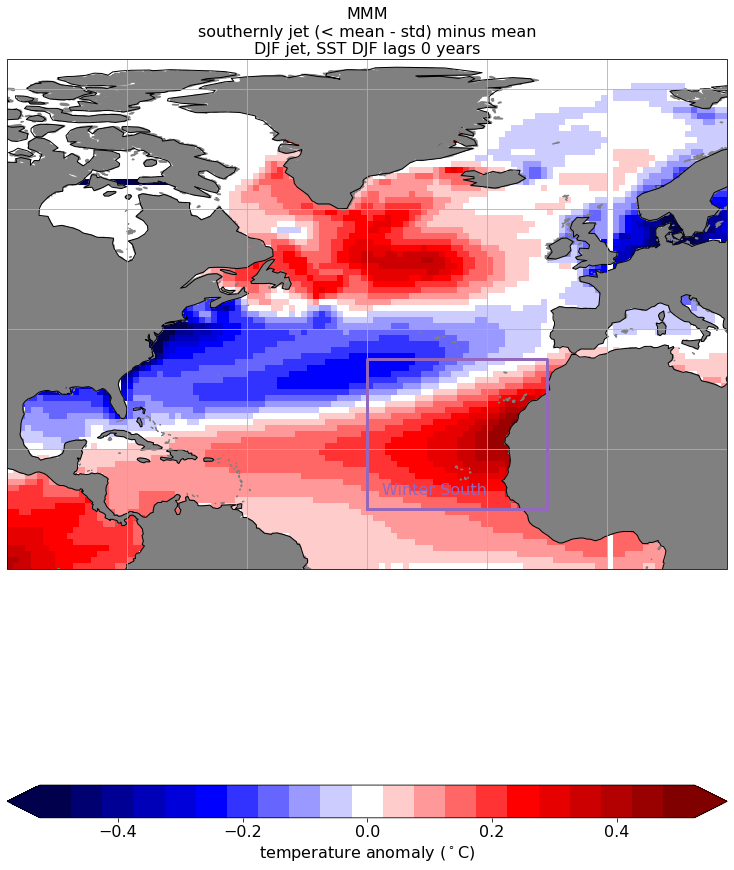

In [35]:
# Loop through each season combination and plot data:
for ss in range(0,1):#ns):
    # Plot multi-model mean: 
    plot_globaly(min1_MMM[ss,:,:]-mean_MMM[ss,:,:],
                 ('MMM\n' + lmin + ' minus mean\n' + season_ts[ss] +
                 ' jet, SST ' + season_field[ss] + ' lags ' + str(plot_lag) + ' years'),'k',
                 (figdir + '/' + 'MMM_' + var_ts + '-' + season_ts[ss] + '_' + var_field +
                 '-' + season_field[ss] + '_min-mean_1std_lag' + str(plot_lag) + '_boxes.png'),vmin,vmax,
                 'Winter',ss)

    plot_globaly(max1_MMM[ss,:,:]-mean_MMM[ss,:,:],
                 ('MMM\n' + lmax + ' minus mean\n' + season_ts[ss] +
                 ' jet, SST ' + season_field[ss] + ' lags ' + str(plot_lag) + ' years'),'k',
                 (figdir + '/' + 'MMM_' + var_ts + '-' + season_ts[ss] + '_' + var_field +
                 '-' + season_field[ss] + '_max-mean_1std_lag' + str(plot_lag) + '_boxes.png'),vmin,vmax,
                 'Winter',ss)

    plot_globaly(max1_MMM[ss,:,:]-min1_MMM[ss,:,:],
                 ('MMM\n' + lmax + ' minus ' + lmin + ' \n' + season_ts[ss] +
                 ' jet, SST ' + season_field[ss] + ' lags ' + str(plot_lag) + ' years'),'k',
                 (figdir + '/' + 'MMM_' + var_ts + '-' + season_ts[ss] + '_' + var_field +
                  '-' + season_field[ss] + '_max-min_1std_lag' + str(plot_lag) + '_boxes.png'),vmind,vmaxd,
                 'Winter',ss)

###### 